In [111]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/GitHub/CMPE255\ Assignment\ -\ 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/GitHub/CMPE255 Assignment - 1


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [113]:
import datetime

Initialize core requirements for the notebook.

In [114]:
directory = "./dataset/"
video_string = "USvideos.csv"
json_string = "US_category_id.json"
us_video = pd.read_csv( directory + video_string )
us_json = pd.read_json( directory + json_string )

For EDA, we use US data as sample and perform exploratory data analysis

In [115]:
print(us_video.shape)
us_video.head()

(40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [116]:
k1 = [[int(j) for j in i.split(".")] for i in us_video["trending_date"]]
k2 = [[int(j) for j in i.split("T")[0].split("-")] for i in us_video["publish_time"]]
z1 = pd.Series([datetime.datetime(2000+i[0],i[2],i[1]) for i in k1])
z2 = pd.Series([datetime.datetime(i[0],i[1],i[2]) for i in k2])
no_of_trending_days = pd.Series([(i-j).days for i,j in zip(z1,z2)])
len_of_description = pd.Series([len(i) for i in us_video["description"].fillna("")])
no_of_tags = pd.Series([len(i.split("|")) for i in us_video["tags"]])
len_of_title = pd.Series([len(i) for i in us_video["title"]])

On prelimnary review, we can identify that some of columns won't directly amount to annything during the training process. Those columns are: video_id, trending date, thumbnail link,title,channel_title,publish_time,tags,description. We will have to do feature engineering to extract relevant feature and would be used in model training. 

In [117]:
print(us_video.nunique())
#Looking for Nulls and type of our data
us_video.info()

video_id                   6351
trending_date               205
title                      6455
channel_title              2207
category_id                  16
publish_time               6269
tags                       6055
views                     40478
likes                     29850
dislikes                   8516
comment_count             13773
thumbnail_link             6352
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
description                6901
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5

We notice that *description* has only 40379 objects, thus it has 570 null/nan values, which would be needed to be handled appropriately. One approach would be to replace them with 0

In [118]:
us_video.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


We have to normalize the dataset, as we can see range of values for these columns is different and would make incorrect prediction on being trained

In [119]:
#us_video =us_video.replace(True,1)
#us_video =us_video.replace(False,-1)

In [120]:
normalize_features = ['likes','views','dislikes','comment_count']
for i in normalize_features:
  us_video[ i + '_log' ] = np.log(us_video[i] + 1)

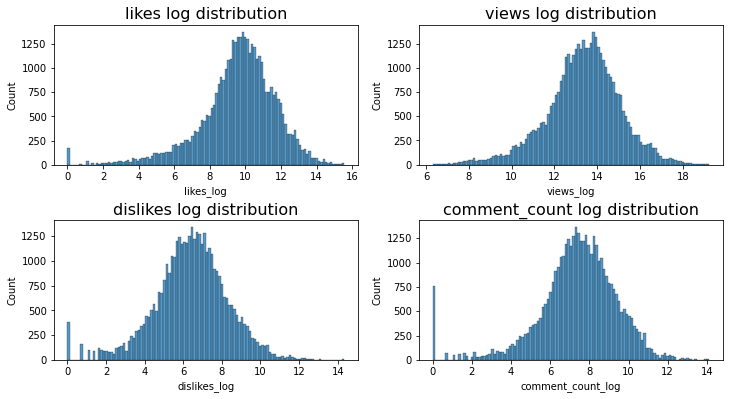

In [121]:
plt.figure(figsize = (12,6))

for i in range(4):
  plt.subplot(2,2,i+1)
  g = sns.histplot(us_video[normalize_features[i]+'_log'])
  g.set_title(normalize_features[i]+" log distribution", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()

In [122]:
categories = {i['id'] : i['snippet']['title'] for i in us_json['items']}

In [123]:
us_video['category_name'] = np.nan
for i in categories.keys():
  us_video.loc[us_video["category_id"] == int(i),"category_name"] = categories[i]

Category Name count
Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Shows                      57
Nonprofits & Activism      57
Name: category_name, dtype: int64


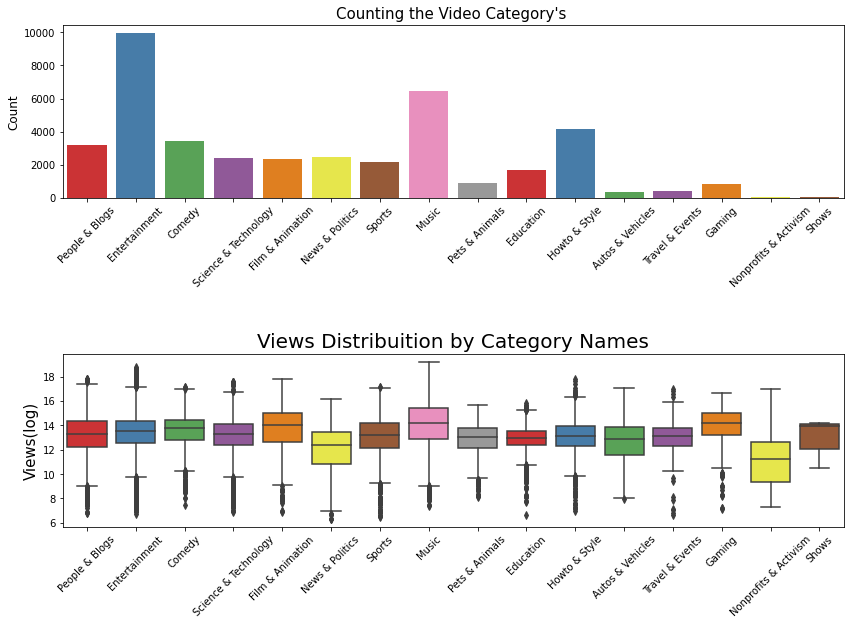

In [124]:
print("Category Name count")
print(us_video.category_name.value_counts())

 
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot(x='category_name', data=us_video, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting the Video Category's ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxplot(x='category_name', y='views_log', data=us_video, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Views Distribuition by Category Names", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Views(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.9, top = 0.9)

plt.show()

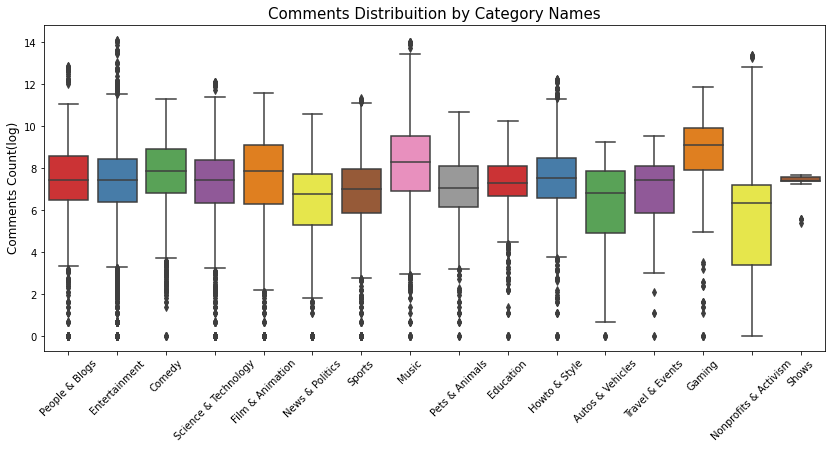

In [125]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='comment_count_log', data=us_video, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Comments Distribuition by Category Names", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Comments Count(log)", fontsize=12)

plt.show()

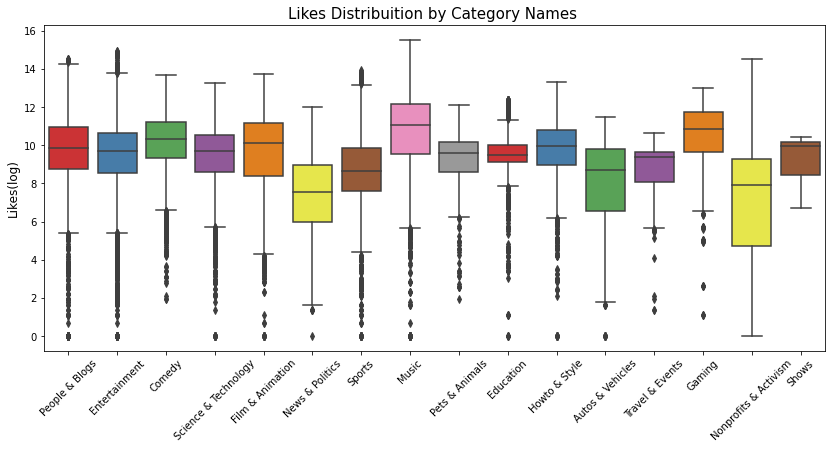

In [126]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likes_log', data=us_video, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Likes Distribuition by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.show()

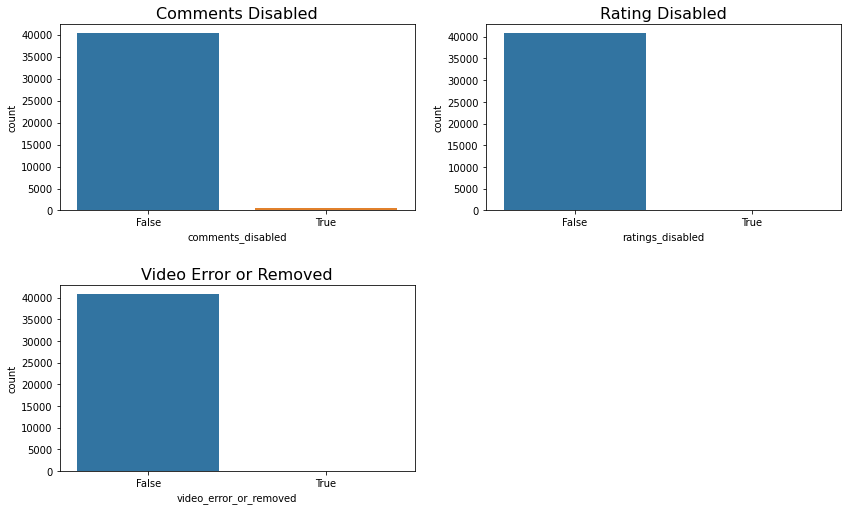

In [127]:
plt.figure(figsize = (14,8))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.subplot(2,2,1)
g = sns.countplot(x='comments_disabled', data=us_video)
g.set_title("Comments Disabled", fontsize=16)

plt.subplot(2,2,2)
g1 = sns.countplot(x='ratings_disabled', data=us_video)
g1.set_title("Rating Disabled", fontsize=16)

plt.subplot(2,2,3)
g2 = sns.countplot(x='video_error_or_removed', data=us_video)
g2.set_title("Video Error or Removed", fontsize=16)
plt.show()

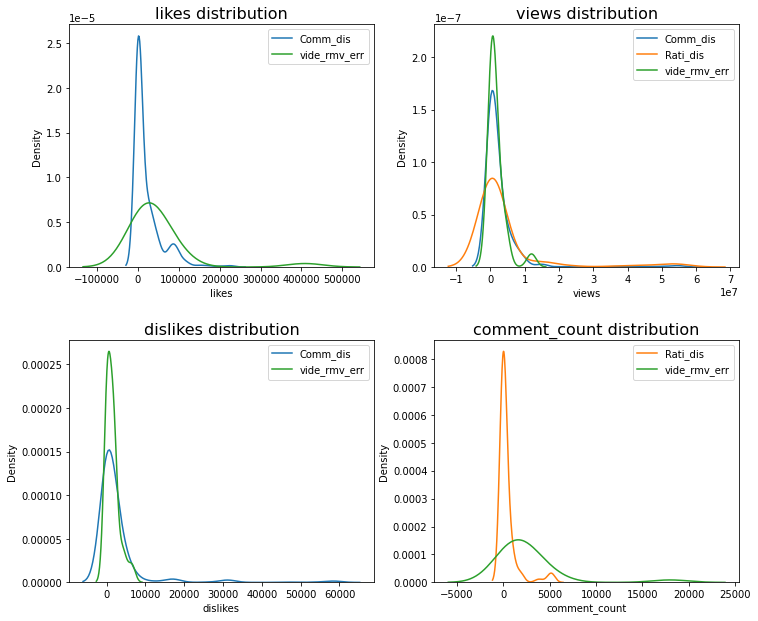

In [128]:
plt.figure(figsize = (12,10))

for i in range(4):
  plt.subplot(2,2,i+1)
  q = sns.kdeplot(us_video[us_video['comments_disabled'] == True][normalize_features[i]], label='Comm_dis',warn_singular=False)
  g = sns.kdeplot(us_video[us_video['ratings_disabled'] == True][normalize_features[i]], label='Rati_dis',warn_singular=False)
  g = sns.kdeplot(us_video[us_video['video_error_or_removed'] == True][normalize_features[i]], label='vide_rmv_err',warn_singular=False) 
  g.set_title(normalize_features[i]+" distribution", fontsize=16)
  plt.subplots_adjust(wspace = 0.2, hspace = 0.3,top = 0.9)
  plt.legend()

plt.show()

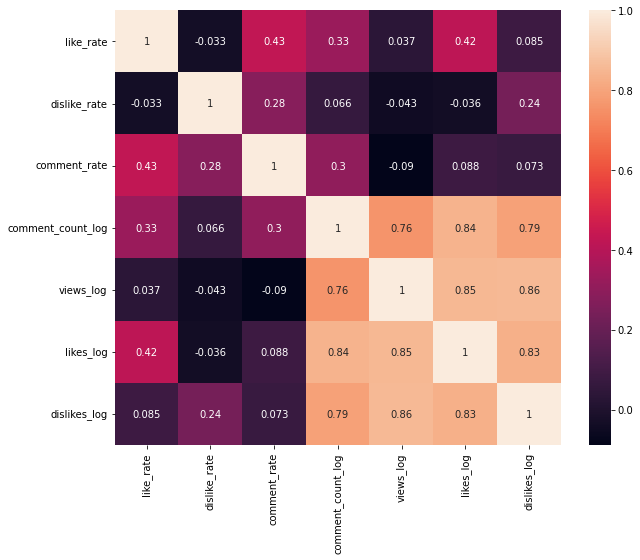

In [129]:
us_video['like_rate'] =  us_video ['likes'] / us_video['views'] * 100
us_video['dislike_rate'] =  us_video ['dislikes'] / us_video['views'] * 100
us_video['dislike_rate'] =  us_video ['dislikes'] / us_video['views'] * 100
us_video['comment_rate'] =  us_video ['comment_count'] / us_video['views'] * 100 

plt.figure(figsize = (10,8))

#Let's verify the correlation of each value
sns.heatmap(us_video[['like_rate', 'dislike_rate', 'comment_rate', 'comment_count_log',
         'views_log','likes_log','dislikes_log', "category_name"]].corr(), annot=True)
plt.show()

Engineering and Selecting features from dataset

In [130]:
relavant_features = ["video_id","category_id","comments_disabled","ratings_disabled","video_error_or_removed"] + [i + "_log" for i in normalize_features]
engineered_dataset = pd.DataFrame(us_video[relavant_features],columns=relavant_features)
engineered_dataset =engineered_dataset.replace(True,1)
engineered_dataset =engineered_dataset.replace(False,-1)

In [135]:
k1 = [[int(j) for j in i.split(".")] for i in us_video["trending_date"]]
k2 = [[int(j) for j in i.split("T")[0].split("-")] for i in us_video["publish_time"]]
z1 = [datetime.datetime(2000+i[0],i[2],i[1]) for i in k1]
z2 = [datetime.datetime(i[0],i[1],i[2]) for i in k2]
engineered_dataset["no_of_trending_days"] = pd.Series([(i-j).days for i,j in zip(z1,z2)])
engineered_dataset["len_of_description"] = pd.Series([np.log(len(i)) if len(i) !=0 else 0 for i in us_video["description"].fillna("")])
engineered_dataset["no_of_tags"] = pd.Series([len(i.split("|")) for i in us_video["tags"]])
engineered_dataset["len_of_title"] = pd.Series([len(i) for i in us_video["title"]])

In [136]:
engineered_dataset

,video_id,category_id,comments_disabled,ratings_disabled,video_error_or_removed,likes_log,views_log,dislikes_log,comment_count_log,no_of_trending_days,len_of_description,no_of_tags,len_of_title
0,2kyS6SvSYSE,22,0.0,0.0,0.0,10.960027,13.525659,7.995307,9.677528,1,7.251345,1,34
1,1ZAPwfrtAFY,24,0.0,0.0,0.0,11.484382,14.698775,8.723719,9.449672,1,6.445720,4,62
2,5qpjK5DgCt4,23,0.0,0.0,0.0,11.891595,14.975981,8.582981,9.009692,2,7.070724,23,53
3,puqaWrEC7tY,24,0.0,0.0,0.0,9.227492,12.745978,6.502790,7.671827,1,7.246368,27,32
4,d380meD0W0M,24,0.0,0.0,0.0,11.792343,14.555413,7.595890,9.771041,2,6.455199,14,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,15,0.0,0.0,0.0,10.549569,14.337638,7.234177,7.885329,27,3.828641,14,28
40945,1h7KV2sjUWY,22,0.0,0.0,0.0,11.002250,13.878297,5.948035,8.278174,27,0.000000,1,26
40946,D6Oy4LfoqsU,24,0.0,0.0,0.0,10.780393,13.879848,6.940222,8.292298,27,6.652863,24,84
40947,oV0zkMe1K8s,1,0.0,0.0,0.0,12.170228,15.549078,7.954021,9.479527,28,8.091933,22,35


We now perform Model Training